# Dialogue Analysis (WIP)

Before we begin, let's import the needed modules and make sure we have ollama server running:

In [27]:
import os

from sdialog.datasets import STAR

get_ipython().system = os.system
!OLLAMA_KEEP_ALIVE=-1 ollama serve > /dev/null 2>&1 &

STAR_PATH = "datasets/STAR/"
STAR.set_path(STAR_PATH)

Let's also use a little hack to make sure figures to be generate and shown are not toooo big.

In [28]:
%%html
<style>
img {
    max-height: 768px !important;
    height: auto !important;
}
</style>

Finally, let's clone the [dialog2flow](https://github.com/idiap/dialog2flow) repo, which we are going to use for our flow-based analysis:

In [29]:
!git clone https://github.com/idiap/dialog2flow.git

fatal: destination path 'dialog2flow' already exists and is not an empty directory.


32768

Great, let's begin! :)

## Flow-based Analysis

### Original dialogues

In previous tutorials we have generated and saved one synthethic dialogue for each original happy dialogue for the "doctor_followup" task.

In this tutorial we will analyse the generated dialogues against the original ones, we first we need to save the original ones as we did with the synthethic ones.

Let's set the path were we will save them:

In [30]:
PATH_OUTPUT = "output/STAR/original"

Get the original dialogues:

In [31]:
original_dialogs = STAR.get_dialogs(task_name="doctor_followup", happy=True, multitask=False)
print('Total number of happy "doctor_followup" dialogues:', len(original_dialogs))

Reading dialogs:   0%|          | 0/6652 [00:00<?, ?it/s]

Total number of happy "doctor_followup" dialogues: 105


And save them:

In [32]:
import os

from typing import Union, List
from tqdm.auto import tqdm


def save_dialogs_by_task(tasks: Union[str, List[str]], path:str, happy: bool = True, multitask: bool = False):
    if type(tasks) == str: tasks = [tasks]

    for task in tqdm(tasks, desc="Saving Dialogs"):
        output_path = os.path.join(path, task) if len(tasks) > 1 else path
        os.makedirs(output_path, exist_ok=True)
        for dialog in STAR.get_dialogs(task_name=task, happy=happy, multitask=multitask):
            with open(os.path.join(output_path, f"{dialog.dialogId}.txt"), "w") as writer:
                writer.write(str(dialog))

save_dialogs_by_task(tasks="doctor_followup", path=PATH_OUTPUT)

Saving Dialogs:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dialogs:   0%|          | 0/6652 [00:00<?, ?it/s]

Let's check we have all the folders we need, one for each generation method and one for the original ones:

In [33]:
%ls output/STAR/

full-generation/
multi-agents/
multi-agents+orchestration/
original/


#### Conversational Graph Generation

Now that we have the dialogues saved in `PATH_OUTPUT`, let's use the `dialog2graph` function to analyze all the dialogues in this folder and produce a global action transition graph that represent them:

[2025-05-14 11:25:00,970.970] Reading conversations...


Dialogues::   0%|          | 0/106 [00:00<?, ?it/s]

[2025-05-14 11:25:01,072.072] Using model 'sergioburdisso/dialog2flow-joint-bert-base' model to generate the embeddings.
[2025-05-14 11:25:01,078.078] Load pretrained SentenceTransformer: sergioburdisso/dialog2flow-joint-bert-base


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-05-14 11:25:03,035.035] Clustering SYSTEM utterances...


Cluster labels (System)::   0%|          | 0/16 [00:00<?, ?it/s]

[2025-05-14 11:25:03,206.206] # clusters: 16
[2025-05-14 11:25:03,207.207] # ground truth labels: None
[2025-05-14 11:25:03,208.208] # Total predictions: 446
[2025-05-14 11:25:03,209.209] Clustering USER utterances...


Cluster labels (User)::   0%|          | 0/55 [00:00<?, ?it/s]

[2025-05-14 11:25:03,901.901] # clusters: 55
[2025-05-14 11:25:03,902.902] # ground truth labels: None
[2025-05-14 11:25:03,903.903] # Total predictions: 448
[2025-05-14 11:25:03,915.915]   Reading trajectories from (output/STAR/original/dialog2flow/trajectories-dialog2flow-joint-bert-base.json)...
[2025-05-14 11:25:03,919.919]     105 trajectories read.
[2025-05-14 11:25:03,920.920]   About to start creating the graph...
[2025-05-14 11:25:03,925.925] Found 6 unique labels with repeated nodes to marge
[2025-05-14 11:25:03,926.926]     > Number of nodes before mergin duplicates: 73
[2025-05-14 11:25:03,927.927]     > Number of nodes after mergin duplicates: 64
[2025-05-14 11:25:03,929.929]   #Nodes before pruning: 64
[2025-05-14 11:25:03,931.931]     Widest path: ['User: Clarify doctor and medication instructions', 'Agent: Inform medication schedule', 'User: Thank you', 'Agent: Good bye']
[2025-05-14 11:25:03,932.932]   #Nodes after pruning: 18
[2025-05-14 11:25:03,935.935]   Saving gra

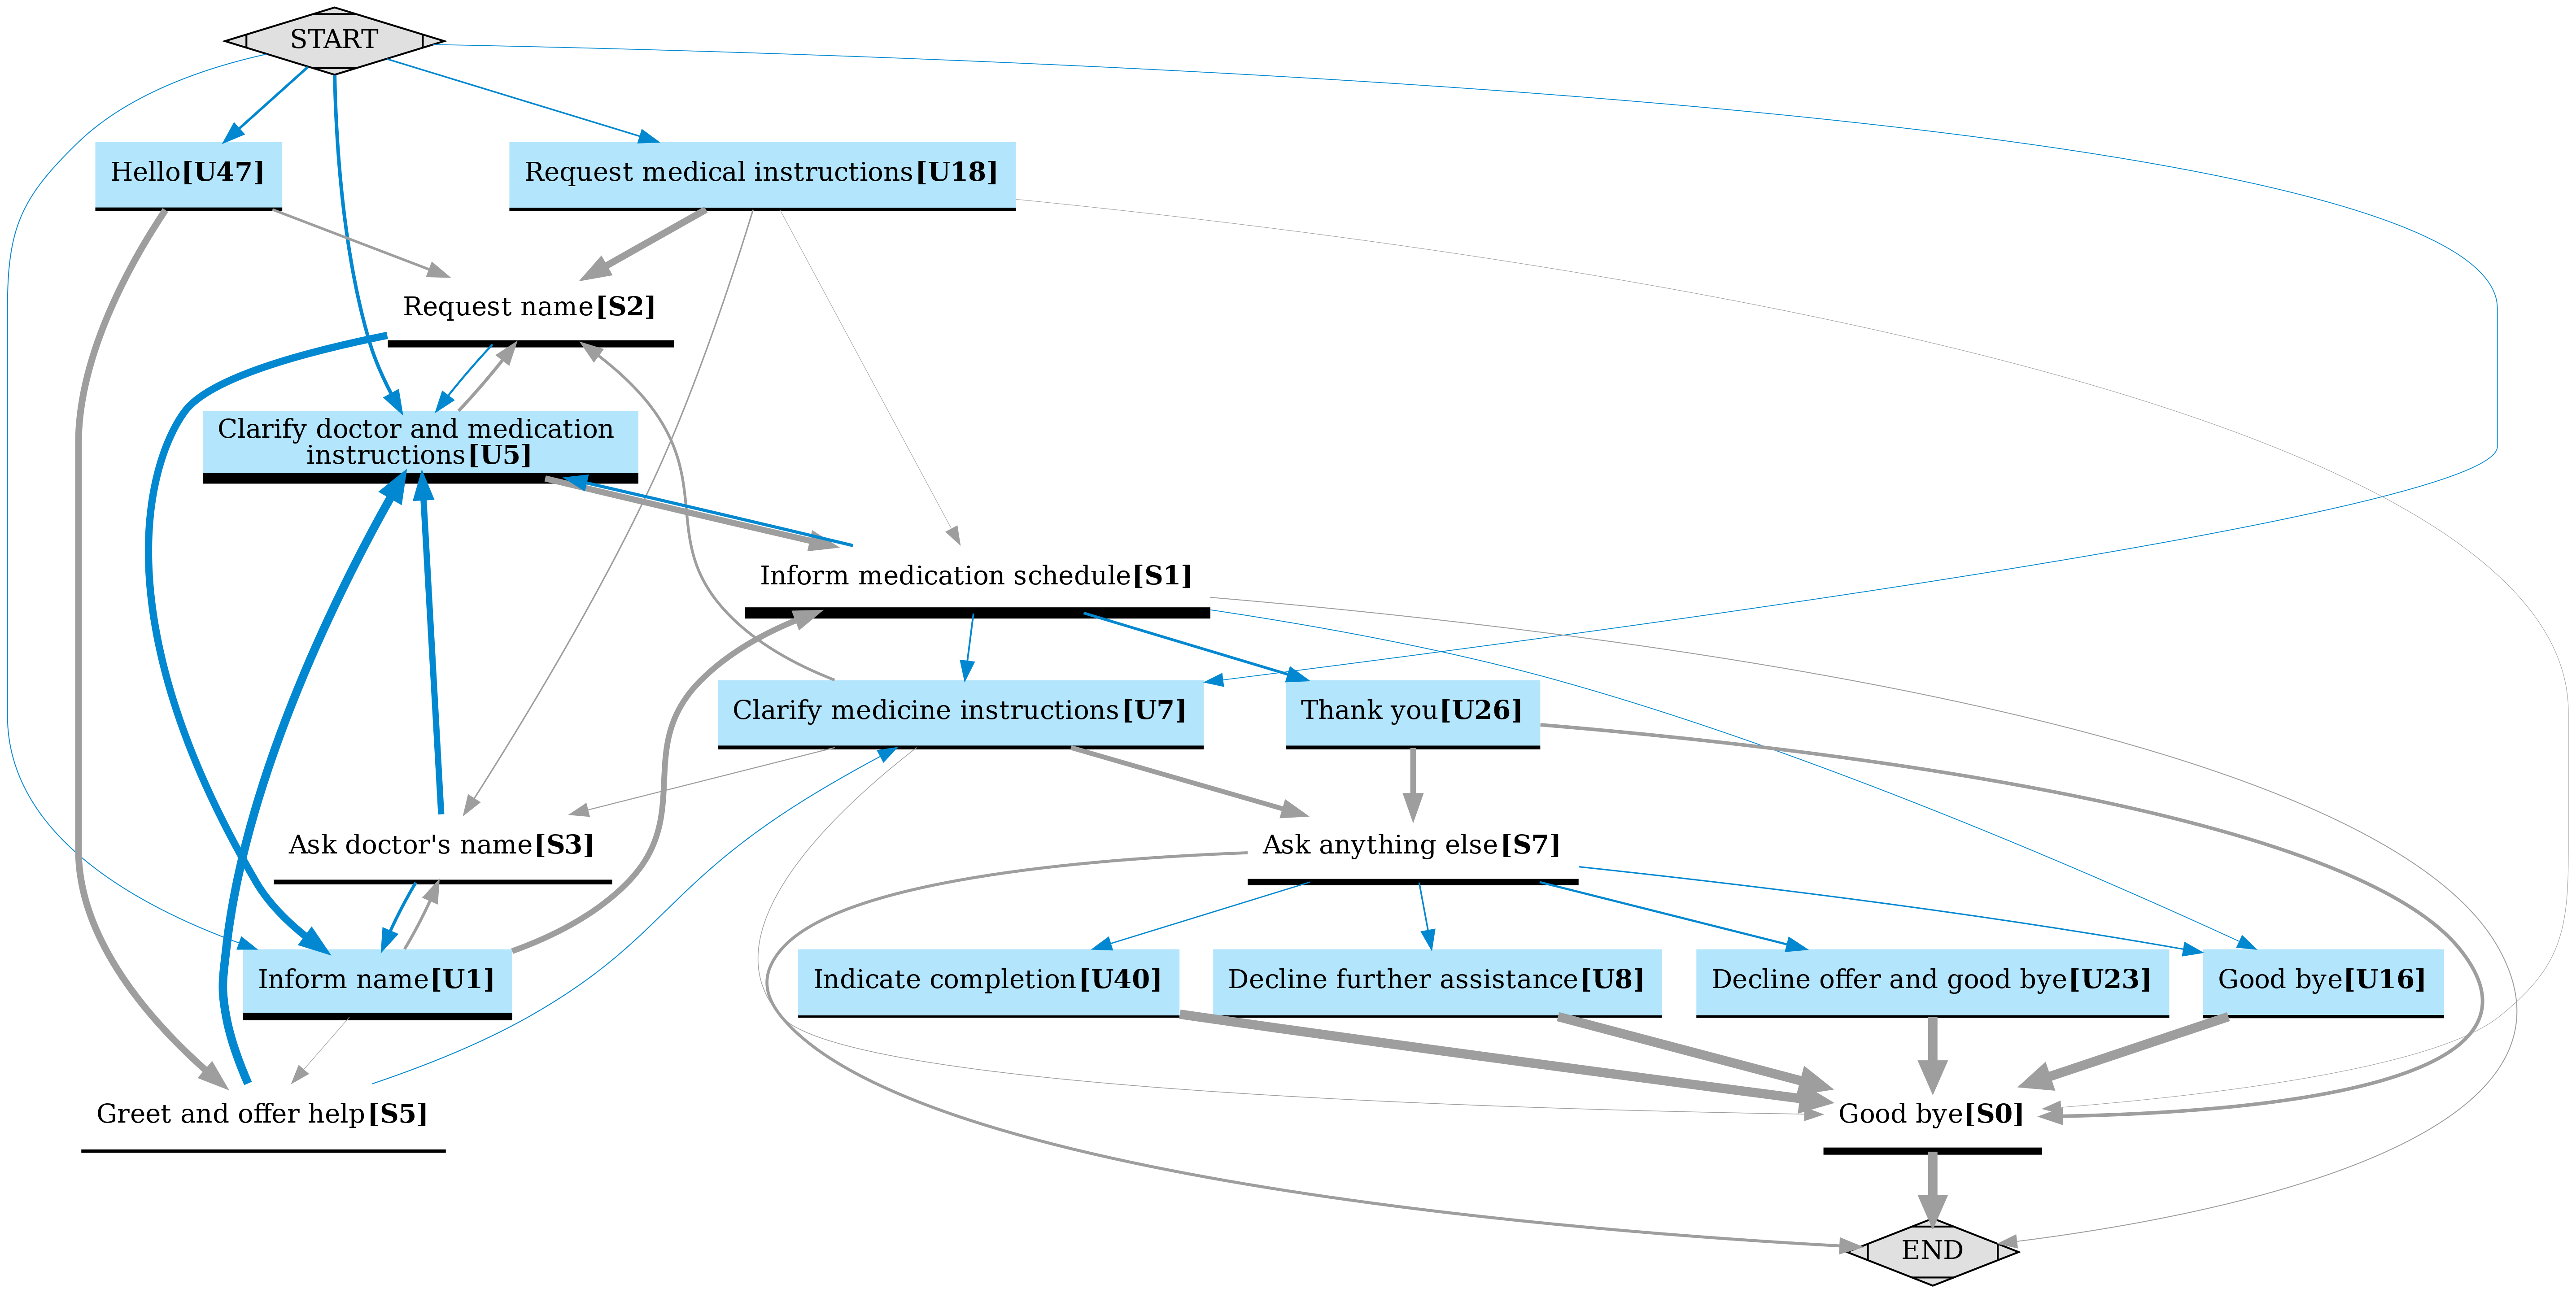

[2025-05-14 11:25:05,884.884]   Finished creating the graph.


In [34]:
from dialog2flow import dialog2graph

graph, nodes = dialog2graph(PATH_OUTPUT)

In the above graph, white nodes are System nodes while blue ones are User nodes.

We can see that the "discovered" graph after the analysis essentially shows a similar flow as the one we know was used for the orchestration under the hood, for this task:

In [35]:
print(STAR.read_graph("doctor_followup"))  # System original graph

digraph doctor_followup  {
    hello -> ask_name;
    ask_name -> doctor_ask_doctor_name;
    doctor_ask_doctor_name -> query;
    query -> doctor_inform_doctors_instructions;
    doctor_inform_doctors_instructions -> anything_else
}


However, note that the graph shown in the figure above was built without any annotation or knowledge about the original graph, just from the content of the conversations alone (text) and still managed to reveal an underline flow that matches closely the real one. This implyes that the humans who create the original dialogues were correctly role playing the characters and produced final dialogues matching the expected flow.

Note that the `dialog2graph()` function returned a `graph` and a `nodes` object, the first one is the graph as a [`NetworkX`](https://networkx.org/)'s [`DiGraph`](https://networkx.org/documentation/stable/reference/classes/digraph.html) object:

In [36]:
graph

And the second one, allow us to get the top-k utterances that were used under the hood to create/discover each node.

We can use it to analyse and debug each step by using the provided codes (e.g. `[U8]`) shown at the end of each node name.

For instance, let's see the utterances associated to the "Decline offer and good bye [U23]" step:

In [37]:
nodes["u23"]

{'name': 'Decline offer and good bye',
 'utterances': ['No, thank you. Goodbye.',
  'No, thank you. Goodbye.',
  'No thank you. Bye.',
  'No. Thanks. Have a good day.',
  'No. Thanks. Have a good day.']}

Alternativally, we can perform this analysis using the the interactive HTML visualization by setting the `out_interactive=True` argument:

In [38]:
_, _ = dialog2graph(PATH_OUTPUT, out_interactive=True, out_png=False)

[2025-05-14 11:25:07,215.215] Reading conversations...


Dialogues::   0%|          | 0/106 [00:00<?, ?it/s]

[2025-05-14 11:25:07,271.271] Using model 'sergioburdisso/dialog2flow-joint-bert-base' model to generate the embeddings.
[2025-05-14 11:25:07,276.276] Load pretrained SentenceTransformer: sergioburdisso/dialog2flow-joint-bert-base


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-05-14 11:25:09,676.676] Clustering SYSTEM utterances...


Cluster labels (System)::   0%|          | 0/16 [00:00<?, ?it/s]

[2025-05-14 11:25:09,835.835] # clusters: 16
[2025-05-14 11:25:09,836.836] # ground truth labels: None
[2025-05-14 11:25:09,837.837] # Total predictions: 446
[2025-05-14 11:25:09,838.838] Clustering USER utterances...


Cluster labels (User)::   0%|          | 0/55 [00:00<?, ?it/s]

[2025-05-14 11:25:10,108.108] # clusters: 55
[2025-05-14 11:25:10,109.109] # ground truth labels: None
[2025-05-14 11:25:10,110.110] # Total predictions: 448
[2025-05-14 11:25:10,121.121]   Reading trajectories from (output/STAR/original/dialog2flow/trajectories-dialog2flow-joint-bert-base.json)...
[2025-05-14 11:25:10,125.125]     105 trajectories read.
[2025-05-14 11:25:10,126.126]   About to start creating the graph...
[2025-05-14 11:25:10,131.131] Found 6 unique labels with repeated nodes to marge
[2025-05-14 11:25:10,132.132]     > Number of nodes before mergin duplicates: 73
[2025-05-14 11:25:10,133.133]     > Number of nodes after mergin duplicates: 64
[2025-05-14 11:25:10,134.134]   #Nodes before pruning: 64
[2025-05-14 11:25:10,137.137]     Widest path: ['User: Clarify doctor and medication instructions', 'Agent: Inform medication schedule', 'User: Thank you', 'Agent: Good bye']
[2025-05-14 11:25:10,138.138]   #Nodes after pruning: 18
[2025-05-14 11:25:10,141.141]   Saving gra

So now you can download the [`output/STAR/original/dialog2flow/graph/dialog2flow-joint-bert-base/visualization/`](output/STAR/original/dialog2flow/graph/dialog2flow-joint-bert-base/visualization/) folder and open the `graph.html` file in it to access the interactive visualization, when hover on nodes you'll see the utterances associated with them.

### Single LLM Full Dialog Generation

[2025-05-14 11:25:10,684.684] Reading conversations...


Dialogues::   0%|          | 0/106 [00:00<?, ?it/s]

[2025-05-14 11:25:10,777.777] Using model 'sergioburdisso/dialog2flow-joint-bert-base' model to generate the embeddings.
[2025-05-14 11:25:10,788.788] Load pretrained SentenceTransformer: sergioburdisso/dialog2flow-joint-bert-base


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

[2025-05-14 11:25:12,573.573] Clustering SYSTEM utterances...


Cluster labels (System)::   0%|          | 0/10 [00:00<?, ?it/s]

[2025-05-14 11:25:12,798.798] # clusters: 10
[2025-05-14 11:25:12,799.799] # ground truth labels: None
[2025-05-14 11:25:12,800.800] # Total predictions: 565
[2025-05-14 11:25:12,801.801] Clustering USER utterances...


Cluster labels (User)::   0%|          | 0/11 [00:00<?, ?it/s]

[2025-05-14 11:25:13,009.009] # clusters: 11
[2025-05-14 11:25:13,010.010] # ground truth labels: None
[2025-05-14 11:25:13,011.011] # Total predictions: 458
[2025-05-14 11:25:13,023.023]   Reading trajectories from (output/STAR/full-generation/txt/dialog2flow/trajectories-dialog2flow-joint-bert-base.json)...
[2025-05-14 11:25:13,029.029]     105 trajectories read.
[2025-05-14 11:25:13,030.030]   About to start creating the graph...
[2025-05-14 11:25:13,034.034] Found 2 unique labels with repeated nodes to marge
[2025-05-14 11:25:13,035.035]     > Number of nodes before mergin duplicates: 23
[2025-05-14 11:25:13,036.036]     > Number of nodes after mergin duplicates: 20
[2025-05-14 11:25:13,037.037]   #Nodes before pruning: 20
[2025-05-14 11:25:13,040.040]     Widest path: ['Agent: Greet and offer help', "User: Confirm doctor's instructions", 'Agent: Provide medical instructions and schedule follow-up', 'User: Thank you and ask anything else', 'Agent: Ask anything else', 'User: Good by

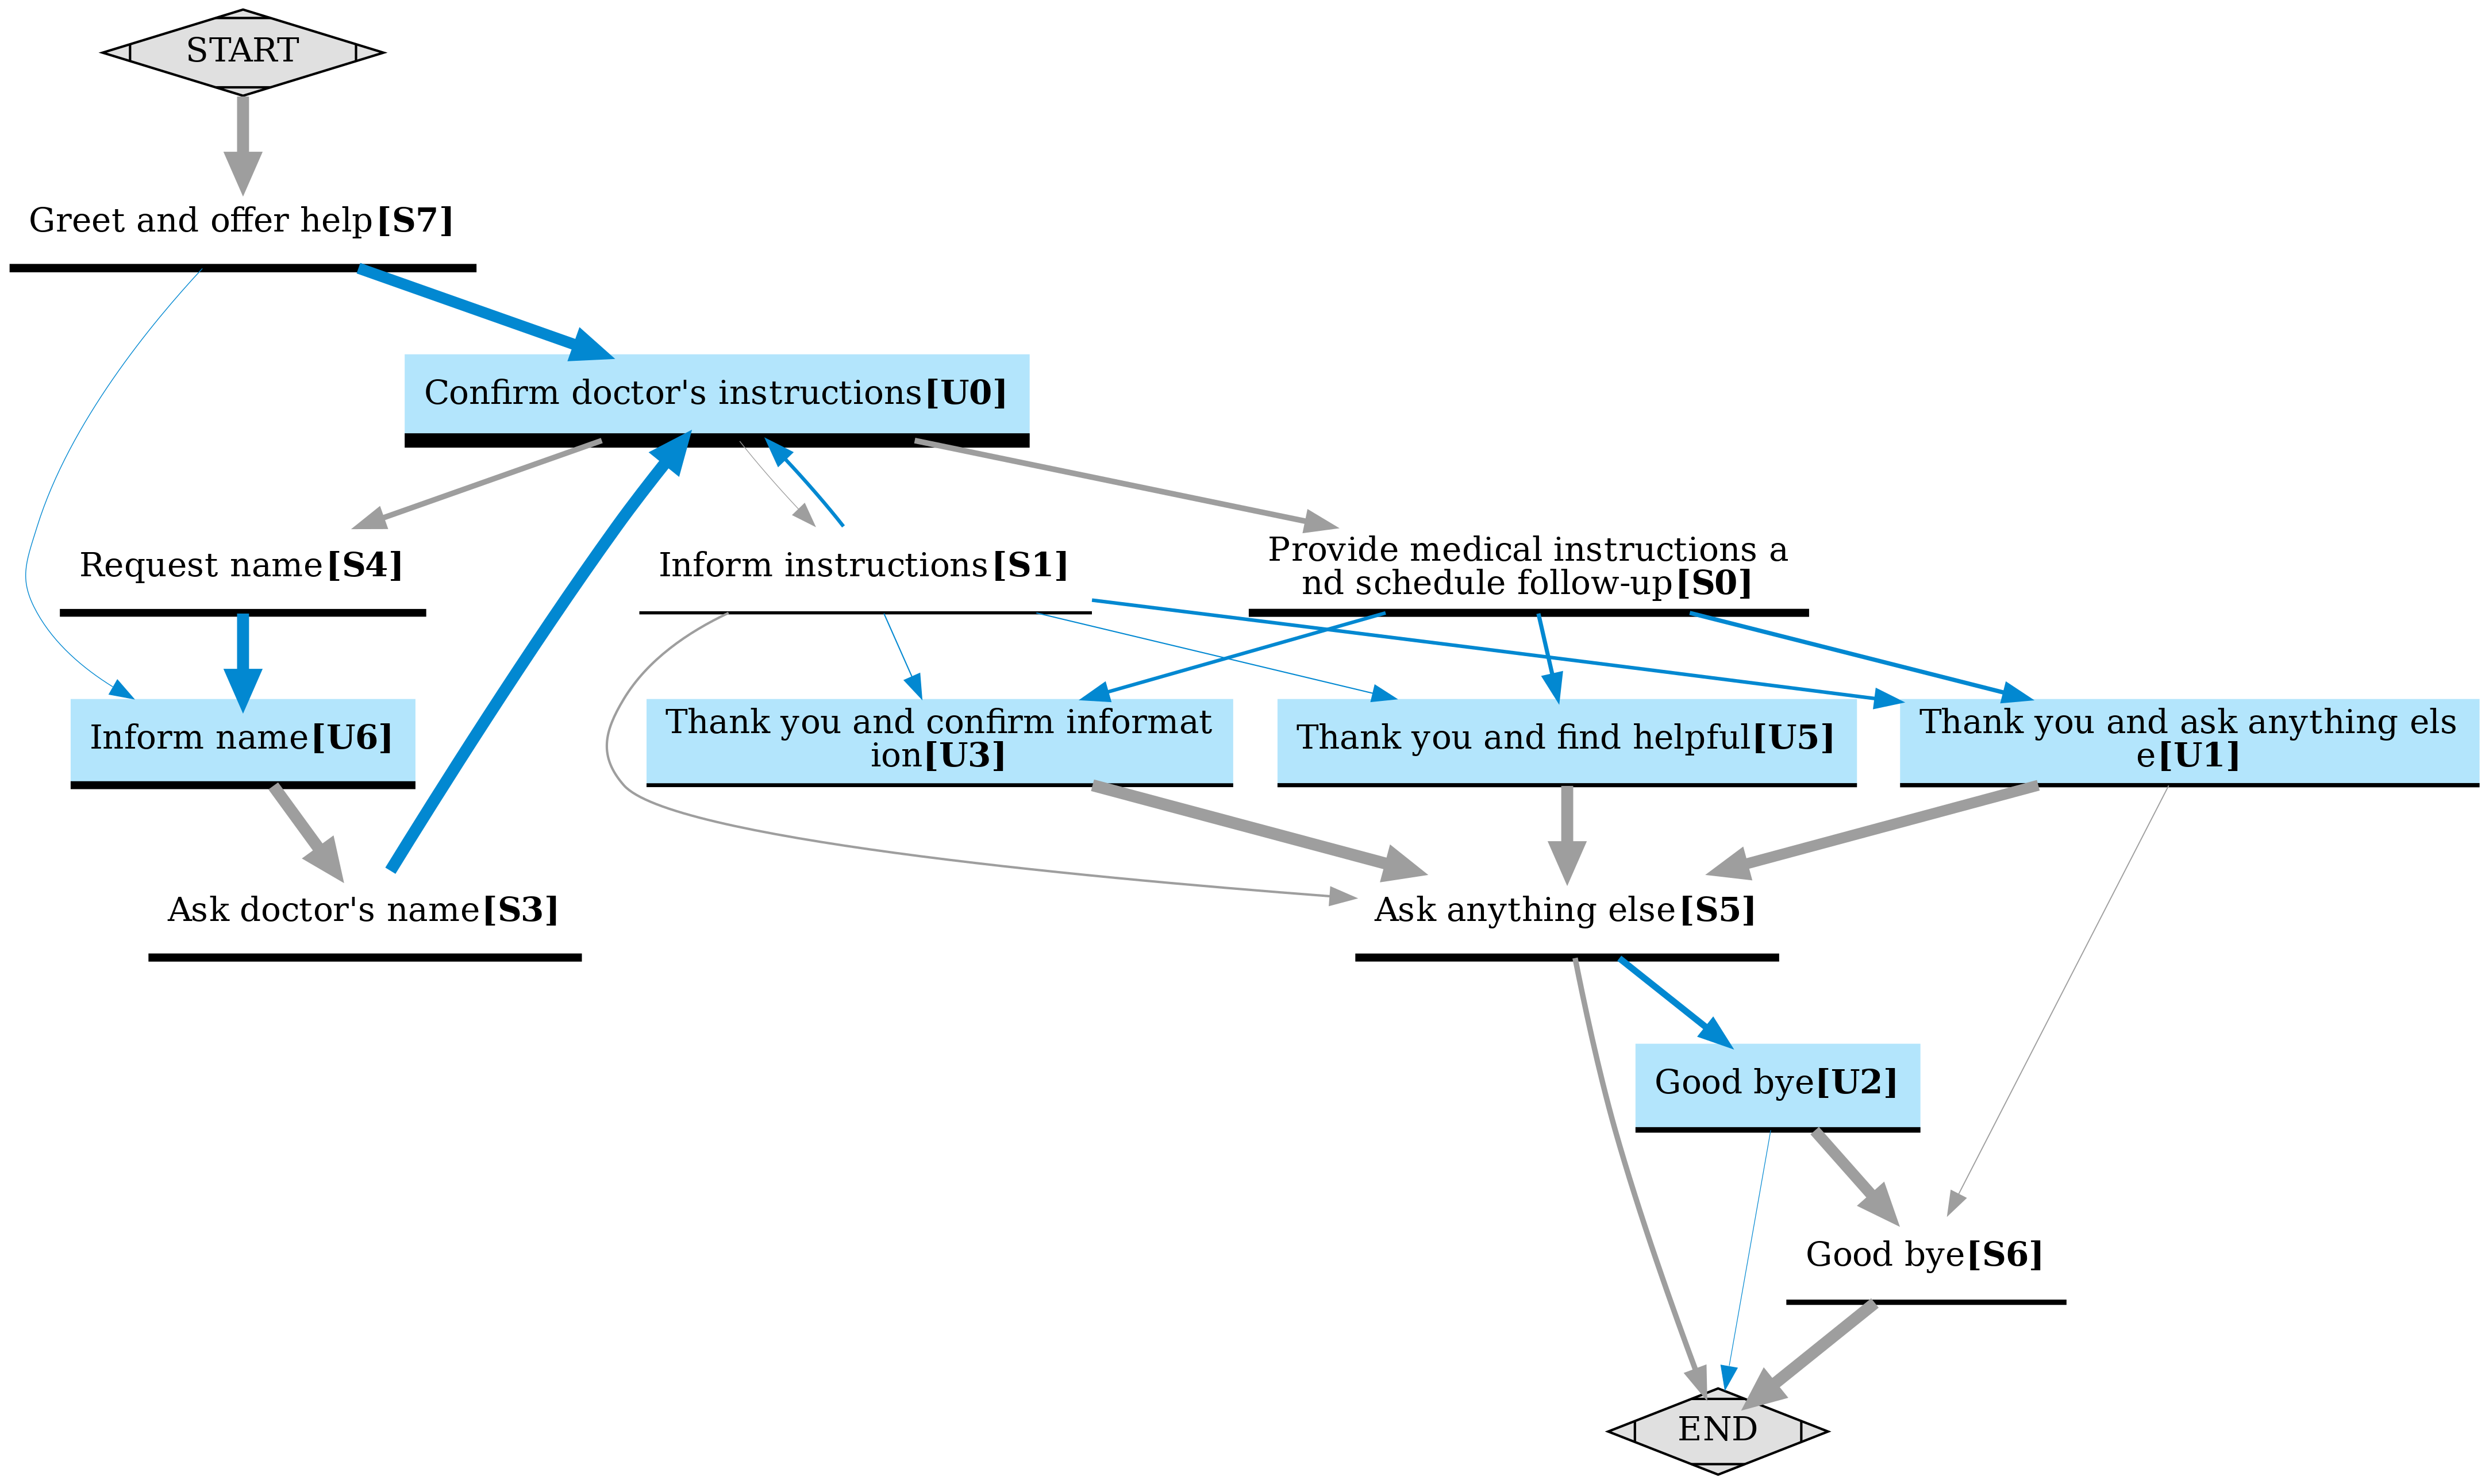

[2025-05-14 11:25:14,019.019]   Finished creating the graph.


In [39]:
_, nodes = dialog2graph("output/STAR/full-generation/txt")

The graph looks quite good, and resambles a similar flow as the original one.

However, why do we have seemly duplicated "Provide medical instructions [S0]" and "Inform instructions [S1]" nodes? let's see what are the utterances used for their labels:

In [40]:
nodes["s0"]

{'name': 'Provide medical instructions and schedule follow-up',
 'utterances': ['Your instructions are: Take the prescribed medication twice daily with meals and schedule another appointment in two months. Also, monitor your blood pressure daily and report any unusual symptoms to our clinic immediately.',
  'Your instructions are: Take the prescribed medication twice a day, maintain a healthy diet and regular exercise routine, and schedule a follow-up appointment in six weeks.',
  'Your instructions are: Take the prescribed medication twice a day, monitor your blood pressure daily and schedule another appointment in two weeks for a follow-up.',
  'Your instructions are: Take the prescribed medication twice daily for two weeks, drink plenty of water and return to the office in four weeks for a follow-up visit.',
  'Your instructions are: Take the prescribed medication twice a day, and follow up with an appointment in two weeks to review progress.']}

In [41]:
nodes["s1"]

{'name': 'Inform instructions',
 'utterances': ['Your instructions are: INSTRUCTIONS.',
  'Your instructions are: INSTRUCTIONS.',
  'Your instructions are: INSTRUCTIONS.',
  'Your instructions are: INSTRUCTIONS.',
  'Your instructions are: INSTRUCTIONS.']}

So it seems the LLM had issues when generating the System turn that inform the instructions in some cases, since in the "Inform instructions [S1]" node we can see there are dialogs in which the instructions were given literally as a template!

And what about the user step "Thank you and ask anything else", the user is not suppose to ask for anything else, but the system. Let's check the node:

In [42]:
nodes["u1"]

{'name': 'Thank you and ask anything else',
 'utterances': ['Thank you. Is there anything else I should know?',
  'Thank you. Is there anything else I should know?',
  'Thank you. Is there anything else I should know?',
  'Thank you! Is there anything else I need to know?',
  'Thank you! Is there anything else I need to know?']}

Ok, "anything else" in the name was referring to _anything else the user should know_, which is fine.

### Role-Play Multi-Agent-based Generation

[2025-05-14 11:29:26,455.455] Reading conversations...


Dialogues::   0%|          | 0/106 [00:00<?, ?it/s]

[2025-05-14 11:29:26,520.520] Using model 'sergioburdisso/dialog2flow-joint-bert-base' model to generate the embeddings.
[2025-05-14 11:29:26,527.527] Load pretrained SentenceTransformer: sergioburdisso/dialog2flow-joint-bert-base


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

[2025-05-14 11:29:29,296.296] Clustering SYSTEM utterances...


Cluster labels (System)::   0%|          | 0/6 [00:00<?, ?it/s]

[2025-05-14 11:29:29,493.493] # clusters: 6
[2025-05-14 11:29:29,494.494] # ground truth labels: None
[2025-05-14 11:29:29,495.495] # Total predictions: 575
[2025-05-14 11:29:29,496.496] Clustering USER utterances...


Cluster labels (User)::   0%|          | 0/7 [00:00<?, ?it/s]

[2025-05-14 11:29:29,643.643] # clusters: 7
[2025-05-14 11:29:29,644.644] # ground truth labels: None
[2025-05-14 11:29:29,645.645] # Total predictions: 470
[2025-05-14 11:29:29,659.659]   Reading trajectories from (output/STAR/multi-agents/txt/dialog2flow/trajectories-dialog2flow-joint-bert-base.json)...
[2025-05-14 11:29:29,665.665]     105 trajectories read.
[2025-05-14 11:29:29,666.666]   About to start creating the graph...
[2025-05-14 11:29:29,670.670]     > Number of nodes after mergin duplicates: 15
[2025-05-14 11:29:29,671.671]   #Nodes before pruning: 15
[2025-05-14 11:29:29,673.673]     Widest path: ['Agent: Greet and offer help', 'User: Request clarification on medication instructions from doctor', 'Agent: Provide medical instructions and ask if anything else is needed', 'User: Confirm medication details and discuss side effects', 'Agent: Good bye']
[2025-05-14 11:29:29,675.675]   #Nodes after pruning: 12
[2025-05-14 11:29:29,677.677]   Saving graph as GraphML format in 'ou

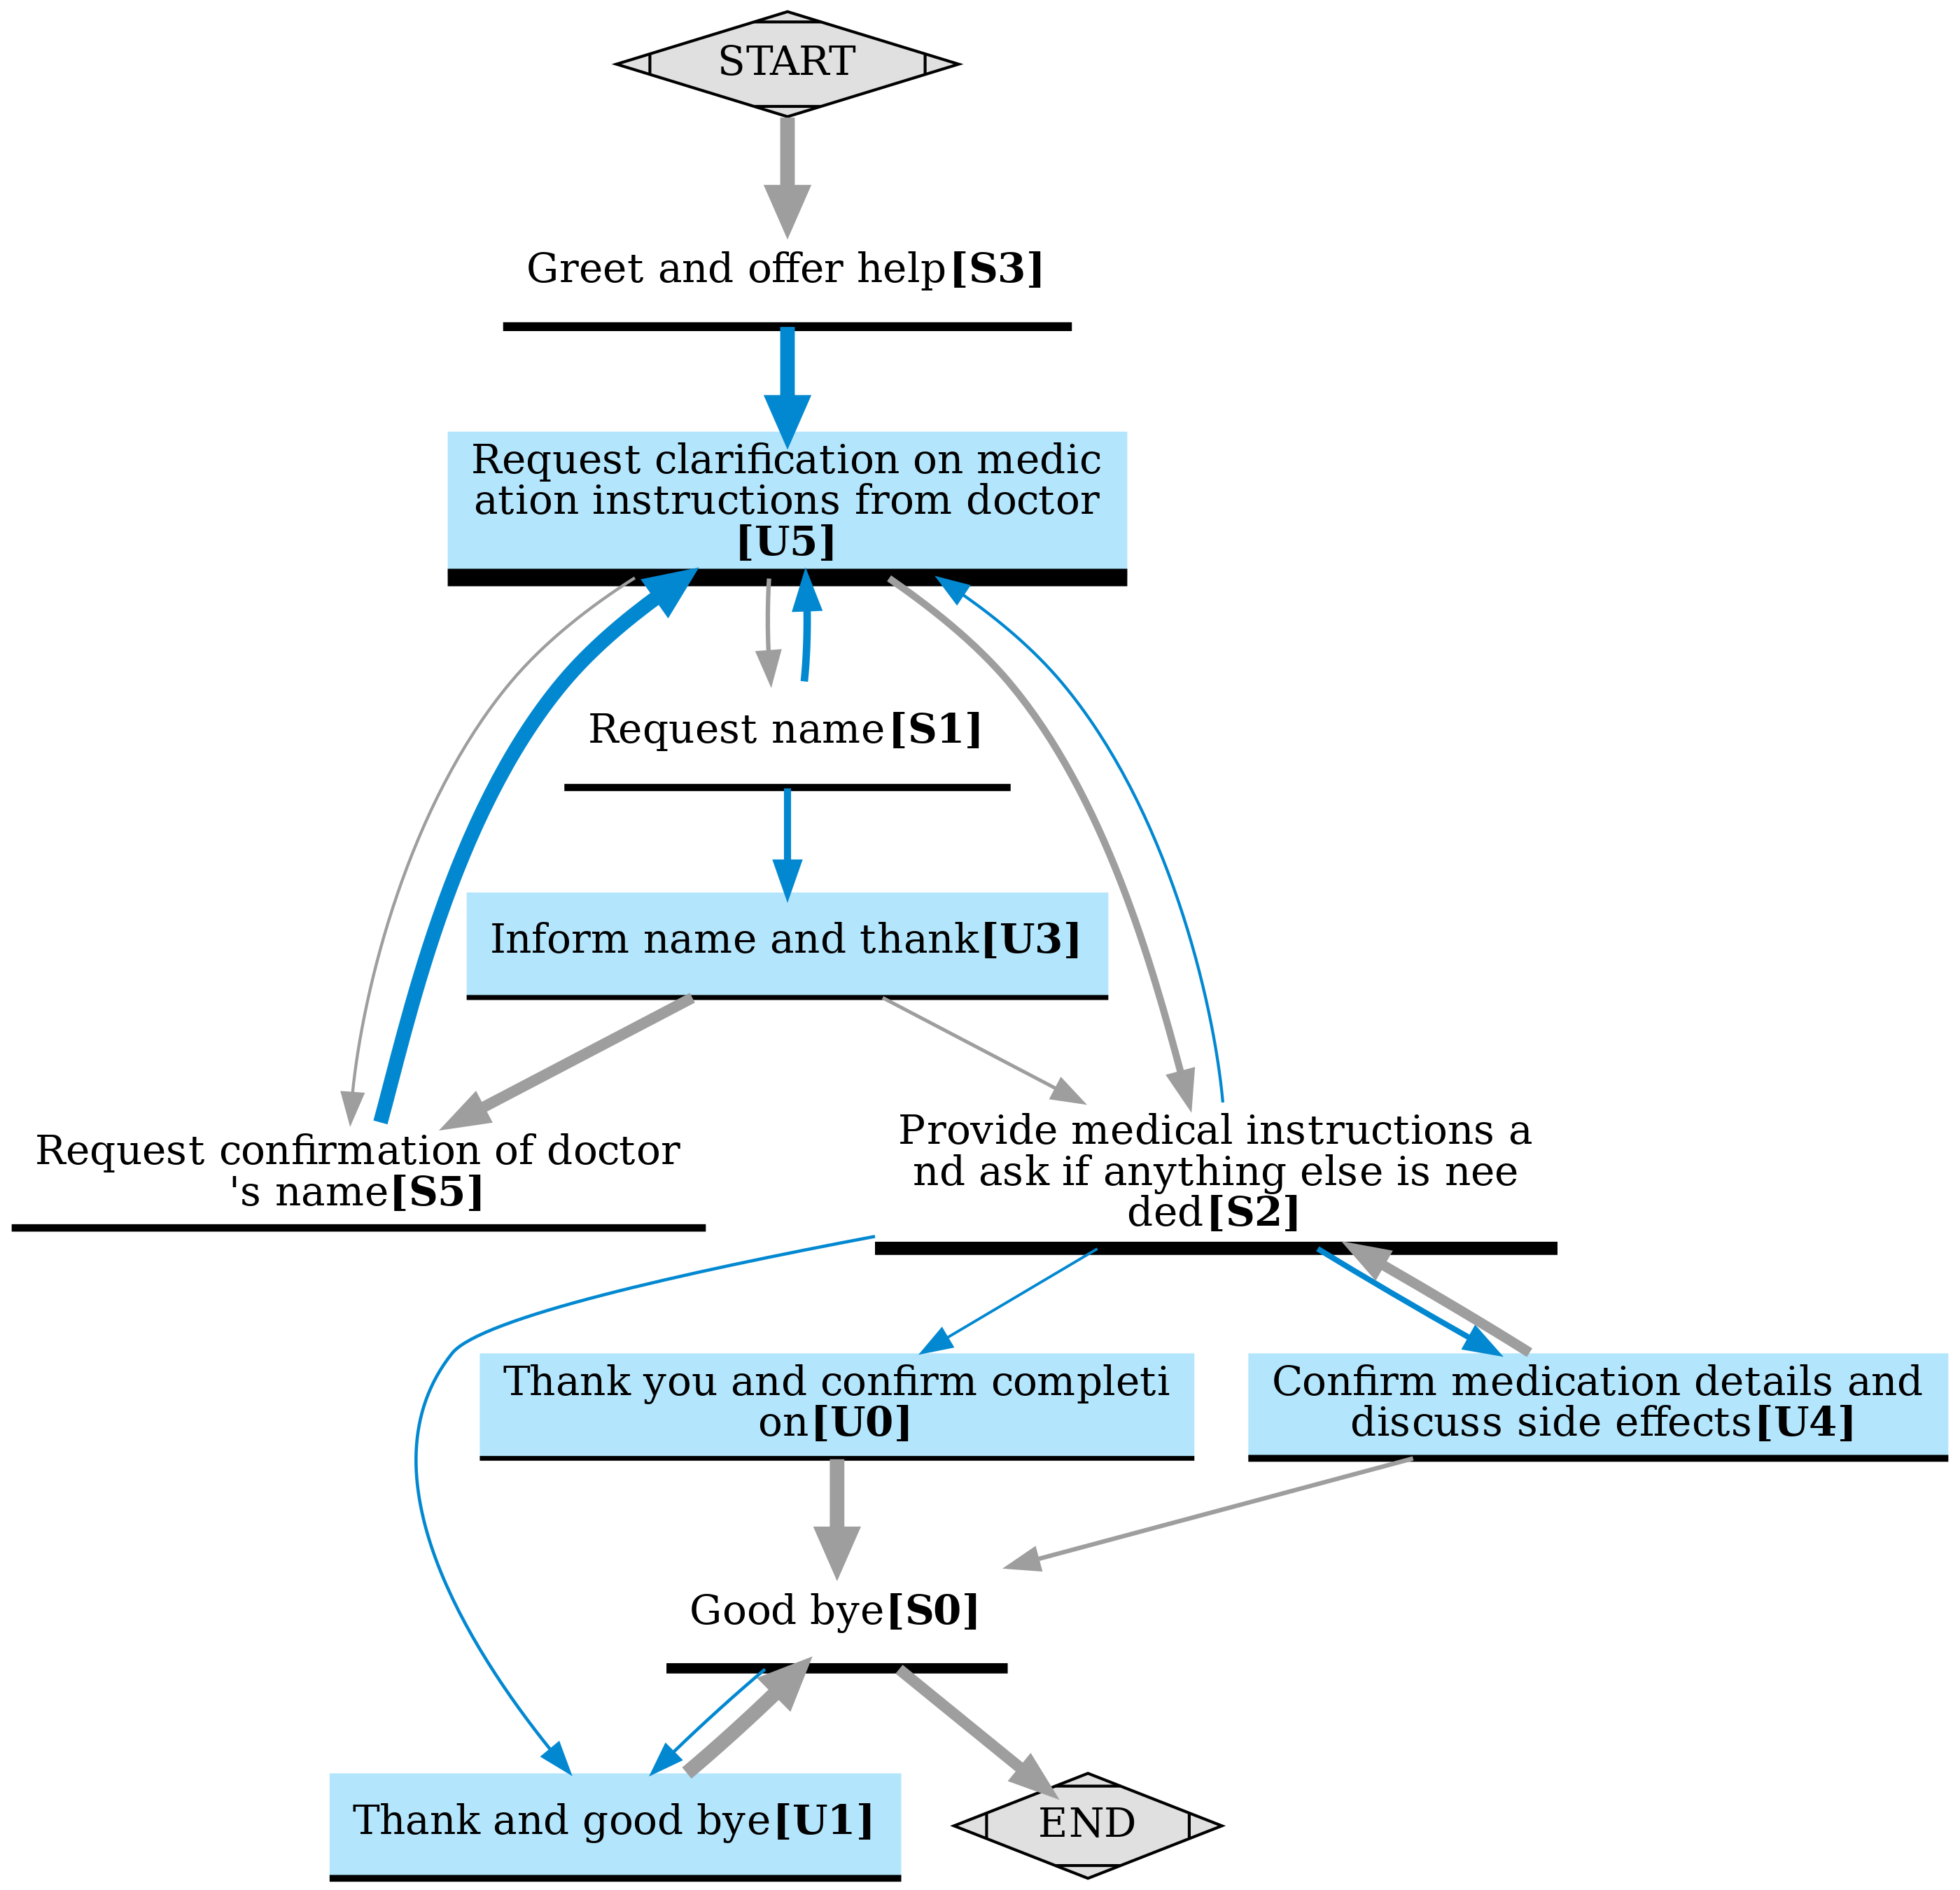

[2025-05-14 11:29:30,359.359]   Finished creating the graph.


In [56]:
from dialog2flow import dialog2graph

_, nodes = dialog2graph("output/STAR/multi-agents/txt", node_thresholds=.5)

> **TODO** Continue from here!

There's no single step for system asking for the doctor's name, why? on the other hand we have steps with multiple acts, for instance, the user to "Request medication instructions **from doctor**" (i.e. the user most of the time provides the name of the doctor already when explaining the reason of the call), and the system inform/confirm the name of the doctor at the same time it provides the required instructions ("Inform doctor and medical instructions"). Let's check the mentioned nodes:

In [44]:
nodes["u0"]

{'name': 'Request medication instructions from doctor',
 'utterances': ['Hi! I just had my appointment with Dr. Alexis but forgot to write down her instructions. Could you please tell me how often I should take my medication?',
  'Yes, it’s Dr. Morgan. Could you please review my treatment plan with me? I want to make sure I’m taking the right medications and know what to expect next.',
  'Hi! I need to follow up on my instructions from Dr. Alexis. Could you remind me how often I should take my medication?',
  'Hi! I was wondering if Dr. Johnson is available for a quick follow-up call? We had an appointment last week and I want to make sure I understood everything correctly regarding my medication regimen.',
  "Hi! Could you please tell me how often I should take my medication according to Dr. Johnson's instructions? I couldn't write them down during our last appointment. Thanks!"]}

In [45]:
nodes["s0"]

{'name': 'Inform doctor and provide instructions',
 'utterances': ["Who is your doctor, Ben? It sounds like you've already seen Dr. Morgan, so I'll proceed with that information. Your instructions are: Take your medication twice a day, in the morning and evening, 30 minutes before meals. Is there anything else that I can do for you?",
  "Who is your doctor? Alexis, since you've mentioned Dr. Johnson, I'll proceed with that information. Your instructions are: Take the medication twice daily, in the morning and evening, exactly as prescribed by Dr. Johnson. Is there anything else that I can do for you?",
  'Your instructions are: Take the medication as prescribed by Dr. Morgan, which is twice daily - once in the morning and once before bedtime. Is there anything else that I can do for you regarding your follow-up with Dr. Morgan or any other concerns?',
  "Who is your doctor, Mark? The information you're looking for is from Dr. Alexis, right? Your instructions are: Take your medication t

This is not necessarily a bad thing per se, in case we don't want this behavior, now that we know that exists, we could set special instructions to force the agents to associate one action per utterance only, although it may sound more "robotic"/less natural.

### Role-Play Multi-Agent-based Generation with Orchestration

[2025-05-14 11:25:18,904.904] Reading conversations...


Dialogues::   0%|          | 0/106 [00:00<?, ?it/s]

[2025-05-14 11:25:18,984.984] Using model 'sergioburdisso/dialog2flow-joint-bert-base' model to generate the embeddings.
[2025-05-14 11:25:18,991.991] Load pretrained SentenceTransformer: sergioburdisso/dialog2flow-joint-bert-base


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

[2025-05-14 11:25:21,357.357] Clustering SYSTEM utterances...


Cluster labels (System)::   0%|          | 0/19 [00:00<?, ?it/s]

[2025-05-14 11:25:21,566.566] # clusters: 19
[2025-05-14 11:25:21,567.567] # ground truth labels: None
[2025-05-14 11:25:21,569.569] # Total predictions: 524
[2025-05-14 11:25:21,570.570] Clustering USER utterances...


Cluster labels (User)::   0%|          | 0/36 [00:00<?, ?it/s]

[2025-05-14 11:25:21,801.801] # clusters: 36
[2025-05-14 11:25:21,802.802] # ground truth labels: None
[2025-05-14 11:25:21,803.803] # Total predictions: 419
[2025-05-14 11:25:21,817.817]   Reading trajectories from (output/STAR/multi-agents+orchestration/txt/dialog2flow/trajectories-dialog2flow-joint-bert-base.json)...
[2025-05-14 11:25:21,823.823]     105 trajectories read.
[2025-05-14 11:25:21,824.824]   About to start creating the graph...
[2025-05-14 11:25:21,829.829] Found 4 unique labels with repeated nodes to marge
[2025-05-14 11:25:21,830.830]     > Number of nodes before mergin duplicates: 57
[2025-05-14 11:25:21,831.831]     > Number of nodes after mergin duplicates: 45
[2025-05-14 11:25:21,832.832]   #Nodes before pruning: 45
[2025-05-14 11:25:21,834.834]     Widest path: ['Agent: Greet and offer help', 'User: Confirm understanding of medical advice from previous appointment', 'Agent: Provide medical instructions and ask if anything else is needed']
[2025-05-14 11:25:21,836

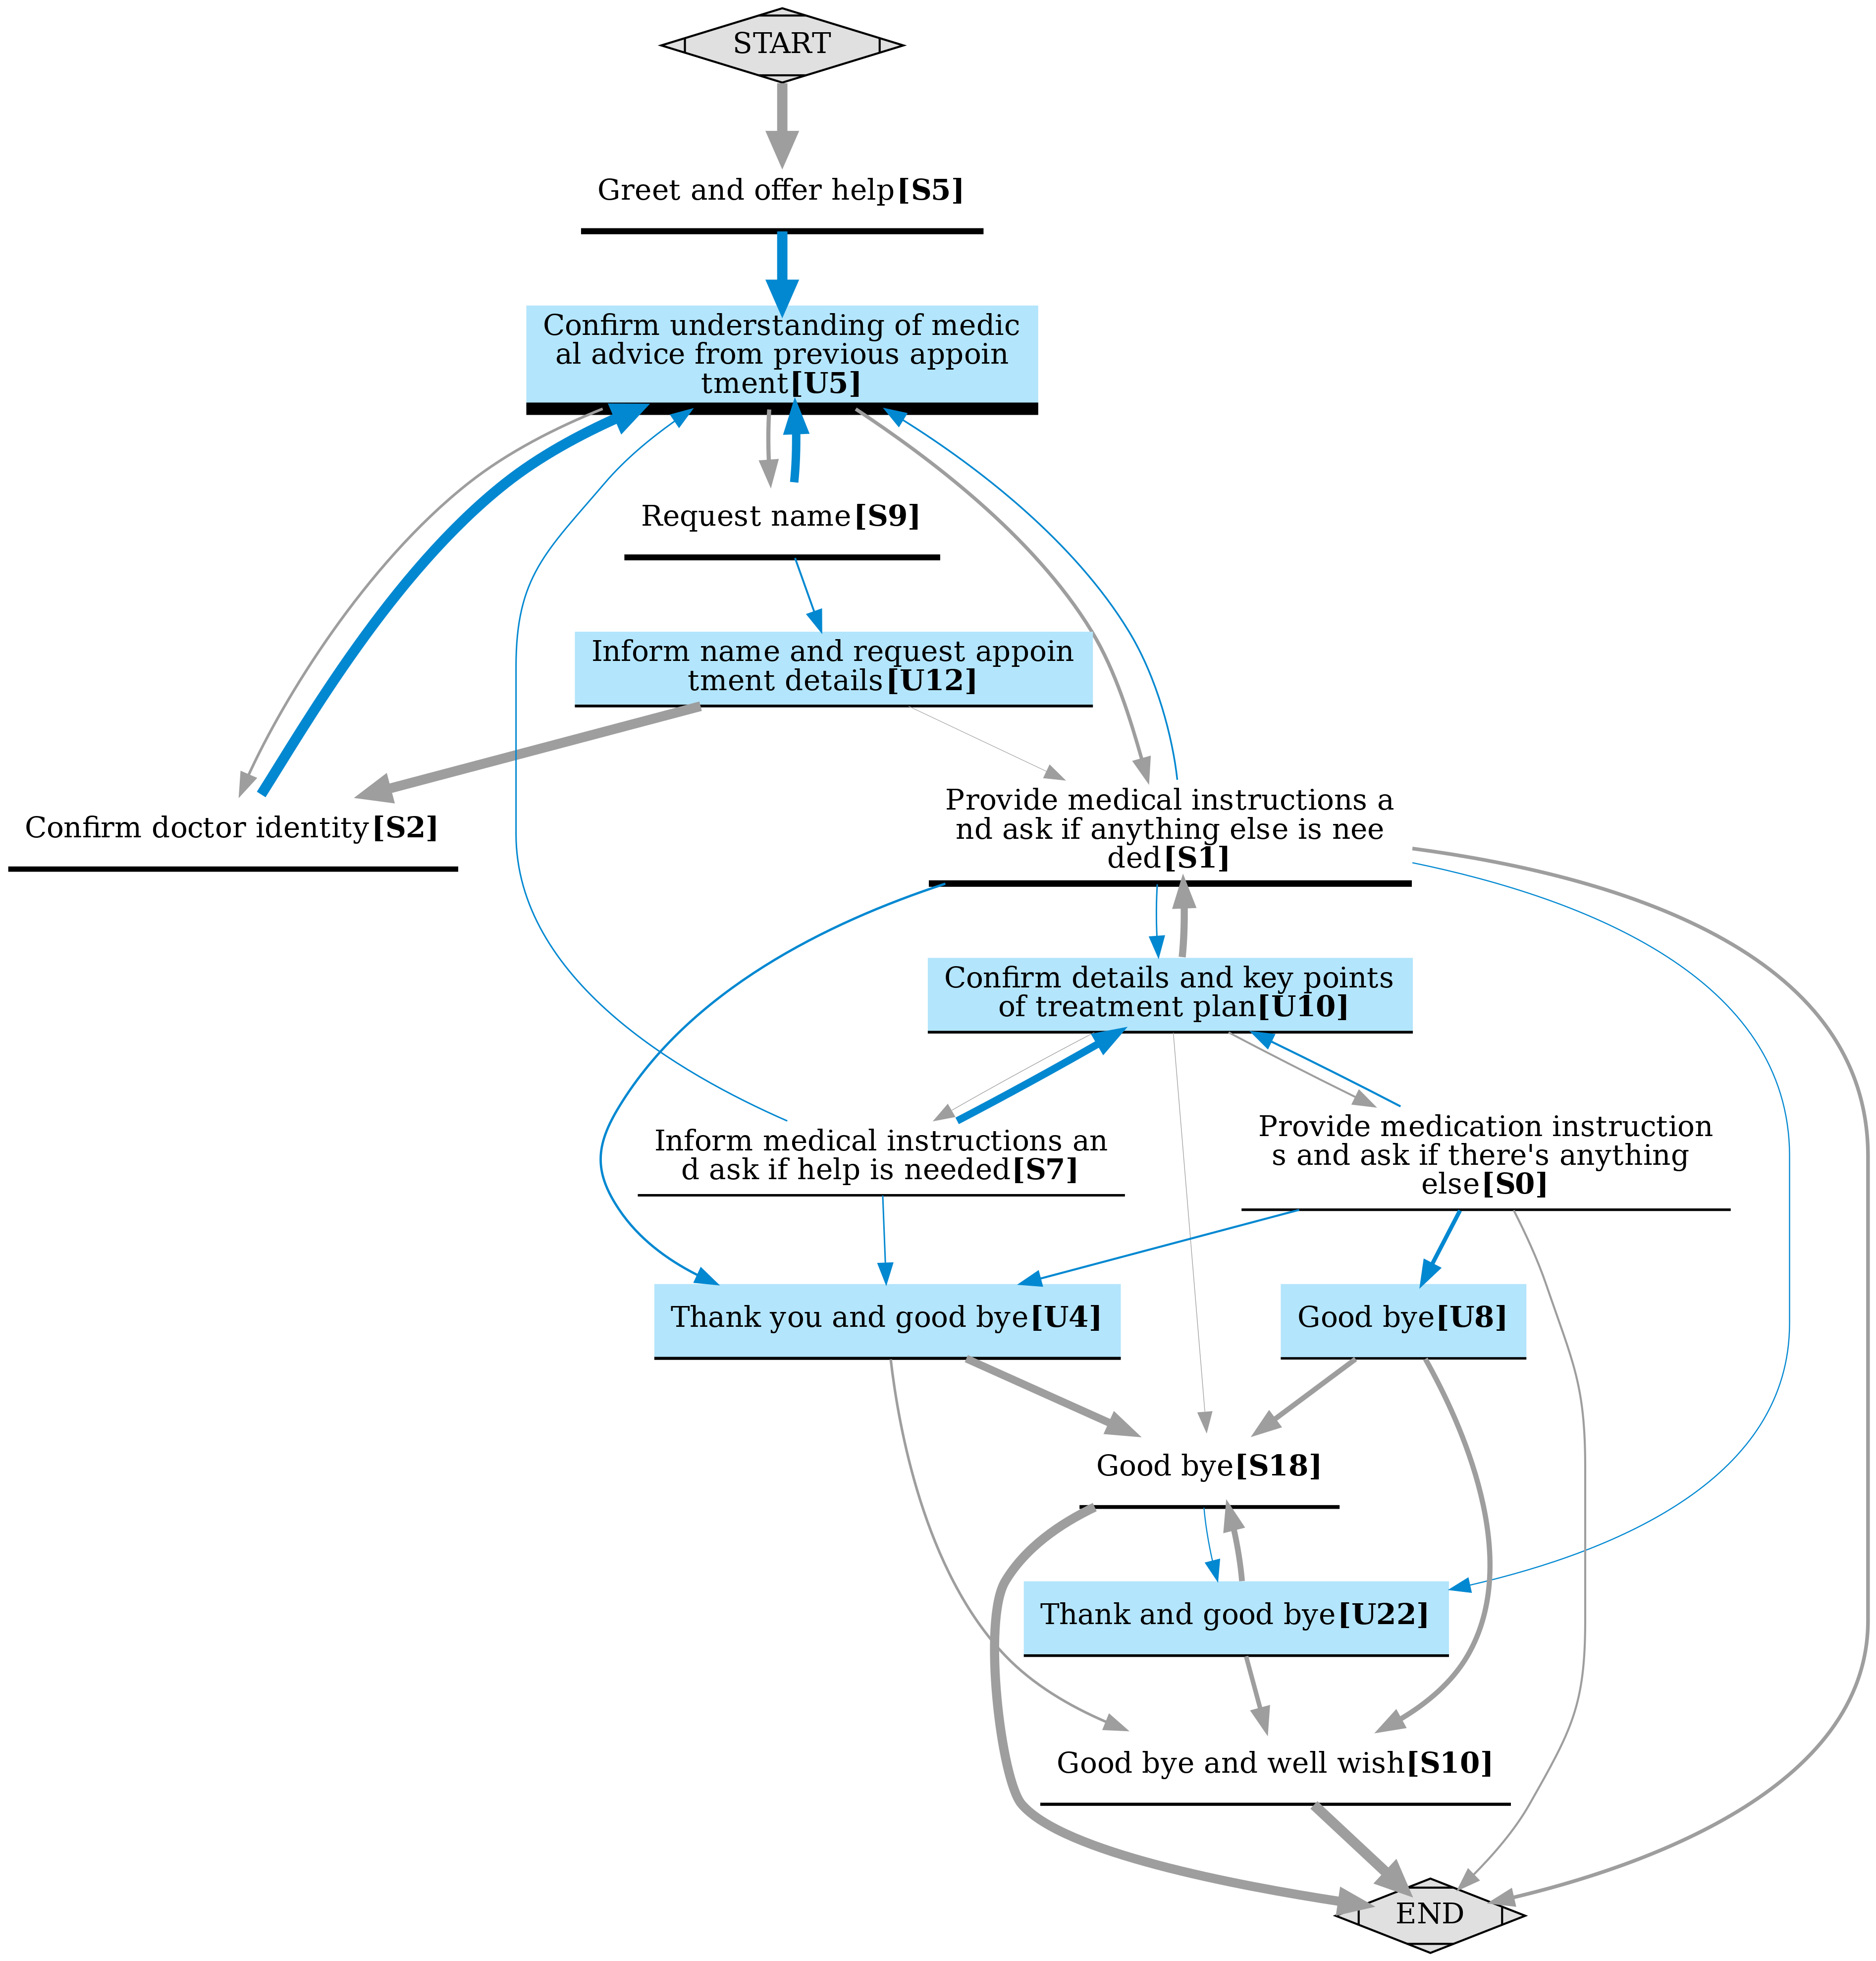

[2025-05-14 11:25:23,249.249]   Finished creating the graph.


In [46]:
PATH_ORCHESTRATION_DIALOGUES = "output/STAR/multi-agents+orchestration/txt"

_, nodes = dialog2graph(PATH_ORCHESTRATION_DIALOGUES, node_thresholds=.35)

We can see here the flow is a little bit more complex with user asking about side effects or trying to schedule a next follow-up with are tasks beyond this ones. This is due to the user actively instructed to "say something random" however, humans were trained to restrict their questions and bahavior in specific ways, if we would like to have simpler dialogues we could instead of simply using the instructions from STAR "as is", we could add extra information.

In [47]:
nodes["u29"]

{'name': 'Confirm medicine schedule and good bye',
 'utterances': ['Thanks for confirming! So, I should be taking my medicine twice a day, once in the morning and again before bed. That’s very helpful. No other assistance is needed at this time, thank you! Bye!',
  'Thank you so much! That’s really helpful. So, it’s twice a day, morning and night, with food. Got it. No further assistance needed from me, thank you! Say goodbye.']}

#### Extra details about `node_thresholds=0.35`

Where did that `node_thresholds=.35` come from? this argument allow us to control the level of details of the graph. It is the distance value for the agglomerative clustering algorithm to cluster utterances as different steps, so the lower the smaller (more similar) clusters, and the greter the number of discovered "steps". We can use the `dialog2trajectories` function to try to find a good threshold value using a dendrogram plot, let's try first with default parameters:

[2025-05-14 11:25:24,706.706] Reading conversations...


Dialogues::   0%|          | 0/106 [00:00<?, ?it/s]

[2025-05-14 11:25:24,761.761] Using model 'sergioburdisso/dialog2flow-joint-bert-base' model to generate the embeddings.
[2025-05-14 11:25:24,768.768] Load pretrained SentenceTransformer: sergioburdisso/dialog2flow-joint-bert-base


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

[2025-05-14 11:25:26,975.975] Clustering SYSTEM utterances...
[2025-05-14 11:25:27,115.115] # clusters: 4
[2025-05-14 11:25:27,117.117] # ground truth labels: None
[2025-05-14 11:25:27,118.118] # Total predictions: 524


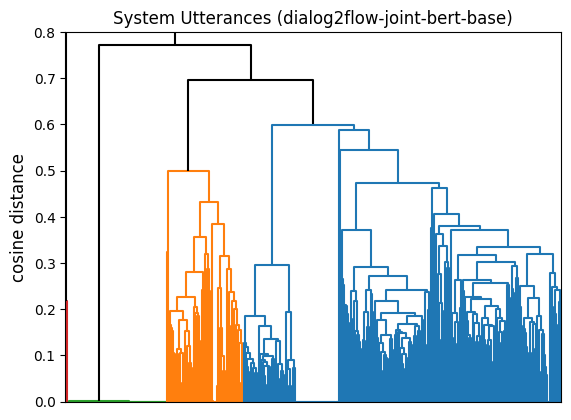

[2025-05-14 11:25:27,441.441] Dendrogram plot for system utterances saved in `output/STAR/multi-agents+orchestration/txt/dialog2flow/plots/dendrogram_dialog2flow-joint-bert-base.system.png`
[2025-05-14 11:25:27,442.442] Clustering USER utterances...
[2025-05-14 11:25:27,541.541] # clusters: 3
[2025-05-14 11:25:27,543.543] # ground truth labels: None
[2025-05-14 11:25:27,544.544] # Total predictions: 419


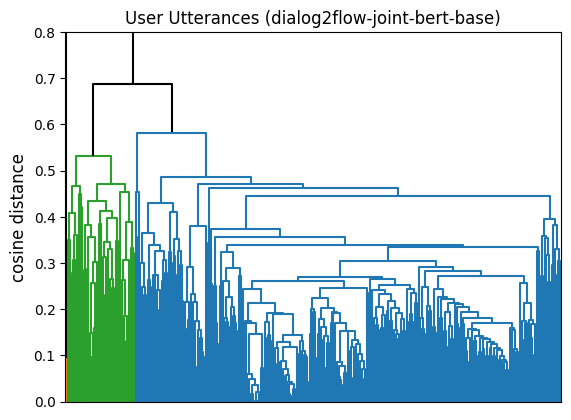

[2025-05-14 11:25:27,855.855] Dendrogram plot for user utterances saved in `output/STAR/multi-agents+orchestration/txt/dialog2flow/plots/dendrogram_dialog2flow-joint-bert-base.user.png`


'output/STAR/multi-agents+orchestration/txt/dialog2flow/trajectories-dialog2flow-joint-bert-base.json'

In [48]:
from dialog2flow import dialog2trajectories

dialog2trajectories(PATH_ORCHESTRATION_DIALOGUES)

We can clearly see, specially in the user, that we need to decrease the threshold value since we have a large (blue) group that is clearly merging too many sub groups. From the plot we can see a value between 0.3 and 0.4 could be a good value, let's say 0.3:

[2025-05-14 11:25:28,052.052] Reading conversations...


Dialogues::   0%|          | 0/106 [00:00<?, ?it/s]

[2025-05-14 11:25:28,113.113] Using model 'sergioburdisso/dialog2flow-joint-bert-base' model to generate the embeddings.
[2025-05-14 11:25:28,118.118] Load pretrained SentenceTransformer: sergioburdisso/dialog2flow-joint-bert-base


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

[2025-05-14 11:25:30,293.293] Clustering SYSTEM utterances...
[2025-05-14 11:25:30,471.471] # clusters: 29
[2025-05-14 11:25:30,473.473] # ground truth labels: None
[2025-05-14 11:25:30,474.474] # Total predictions: 524


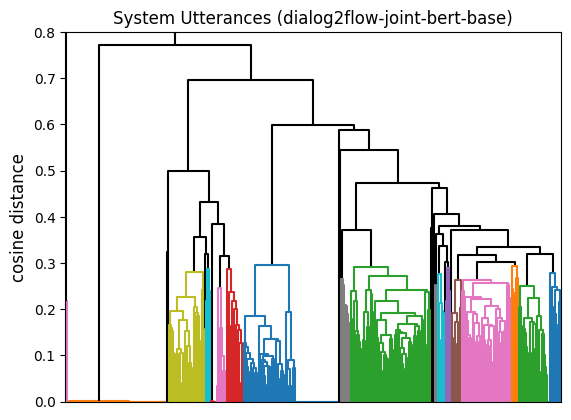

[2025-05-14 11:25:30,811.811] Dendrogram plot for system utterances saved in `output/STAR/multi-agents+orchestration/txt/dialog2flow/plots/dendrogram_dialog2flow-joint-bert-base.system.png`
[2025-05-14 11:25:30,812.812] Clustering USER utterances...
[2025-05-14 11:25:31,023.023] # clusters: 64
[2025-05-14 11:25:31,025.025] # ground truth labels: None
[2025-05-14 11:25:31,026.026] # Total predictions: 419


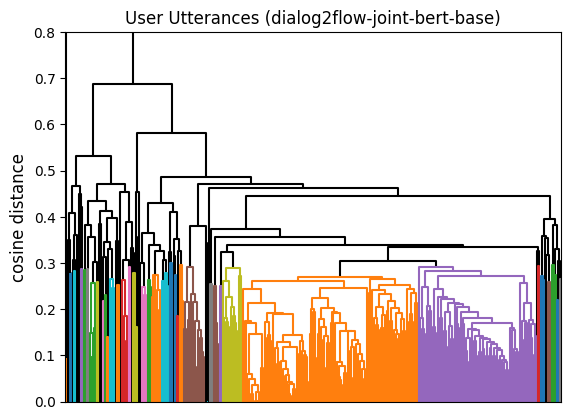

[2025-05-14 11:25:31,364.364] Dendrogram plot for user utterances saved in `output/STAR/multi-agents+orchestration/txt/dialog2flow/plots/dendrogram_dialog2flow-joint-bert-base.user.png`


'output/STAR/multi-agents+orchestration/txt/dialog2flow/trajectories-dialog2flow-joint-bert-base.json'

In [49]:
dialog2trajectories(PATH_ORCHESTRATION_DIALOGUES, thresholds=0.3)

That looks much better, but what happend if we think that the threshold should be different between the user and the system? we can pass two threshold in order to control it. In our example, we know system interactions should be simpler than user so make sense to use a "more abstract"/simpler steps to analyse it. In fact, let's say we believe/think to know the right or a good number of actions to be discovered, we can pass to `dialog2flow` directly the number of actions/steps too, instead of the threshold. For instance, let's say we think 10 steps is good for the system, and a threshold of 0.3 for user is also good, then we can:

[2025-05-14 11:25:31,513.513] Reading conversations...


Dialogues::   0%|          | 0/106 [00:00<?, ?it/s]

[2025-05-14 11:25:31,932.932] Using model 'sergioburdisso/dialog2flow-joint-bert-base' model to generate the embeddings.
[2025-05-14 11:25:31,938.938] Load pretrained SentenceTransformer: sergioburdisso/dialog2flow-joint-bert-base


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

[2025-05-14 11:25:34,120.120] Clustering SYSTEM utterances...
[2025-05-14 11:25:34,262.262] # clusters: 10
[2025-05-14 11:25:34,263.263] # ground truth labels: None
[2025-05-14 11:25:34,265.265] # Total predictions: 524


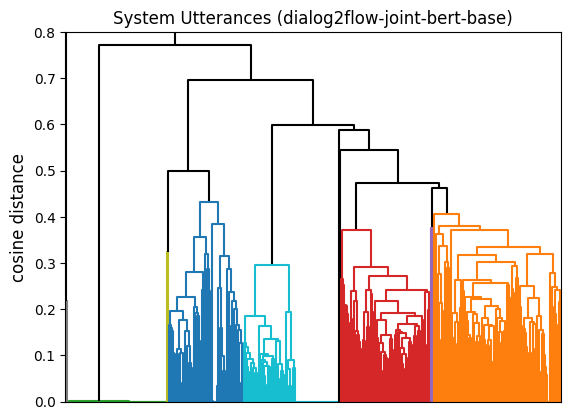

[2025-05-14 11:25:34,589.589] Dendrogram plot for system utterances saved in `output/STAR/multi-agents+orchestration/txt/dialog2flow/plots/dendrogram_dialog2flow-joint-bert-base.system.png`
[2025-05-14 11:25:34,590.590] Clustering USER utterances...
[2025-05-14 11:25:34,803.803] # clusters: 64
[2025-05-14 11:25:34,804.804] # ground truth labels: None
[2025-05-14 11:25:34,805.805] # Total predictions: 419


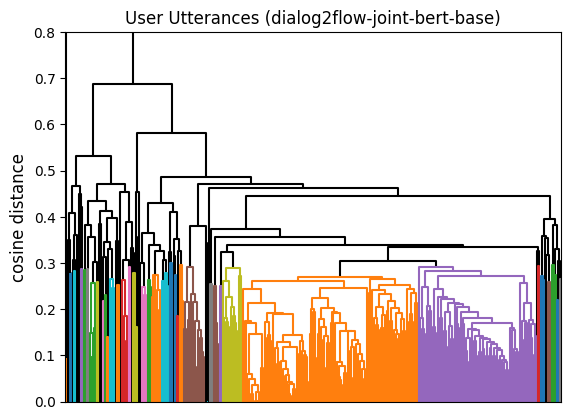

[2025-05-14 11:25:35,144.144] Dendrogram plot for user utterances saved in `output/STAR/multi-agents+orchestration/txt/dialog2flow/plots/dendrogram_dialog2flow-joint-bert-base.user.png`


'output/STAR/multi-agents+orchestration/txt/dialog2flow/trajectories-dialog2flow-joint-bert-base.json'

In [50]:
dialog2trajectories(PATH_ORCHESTRATION_DIALOGUES, thresholds=[10, 0.3])

Finally, once we find the right threshold values for right level of abstraction that is required by our analysis, then we can pass them to our `dialog2graph()` function:

[2025-05-14 11:25:35,326.326] Reading conversations...


Dialogues::   0%|          | 0/106 [00:00<?, ?it/s]

[2025-05-14 11:25:35,378.378] Using model 'sergioburdisso/dialog2flow-joint-bert-base' model to generate the embeddings.
[2025-05-14 11:25:35,384.384] Load pretrained SentenceTransformer: sergioburdisso/dialog2flow-joint-bert-base


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

[2025-05-14 11:25:37,542.542] Clustering SYSTEM utterances...


Cluster labels (System)::   0%|          | 0/10 [00:00<?, ?it/s]

[2025-05-14 11:25:37,715.715] # clusters: 10
[2025-05-14 11:25:37,716.716] # ground truth labels: None
[2025-05-14 11:25:37,717.717] # Total predictions: 524
[2025-05-14 11:25:37,718.718] Clustering USER utterances...


Cluster labels (User)::   0%|          | 0/64 [00:00<?, ?it/s]

[2025-05-14 11:25:38,056.056] # clusters: 64
[2025-05-14 11:25:38,057.057] # ground truth labels: None
[2025-05-14 11:25:38,058.058] # Total predictions: 419
[2025-05-14 11:25:38,071.071]   Reading trajectories from (output/STAR/multi-agents+orchestration/txt/dialog2flow/trajectories-dialog2flow-joint-bert-base.json)...
[2025-05-14 11:25:38,077.077]     105 trajectories read.
[2025-05-14 11:25:38,078.078]   About to start creating the graph...
[2025-05-14 11:25:38,083.083] Found 3 unique labels with repeated nodes to marge
[2025-05-14 11:25:38,084.084]     > Number of nodes before mergin duplicates: 76
[2025-05-14 11:25:38,085.085]     > Number of nodes after mergin duplicates: 55
[2025-05-14 11:25:38,086.086]   #Nodes before pruning: 55
[2025-05-14 11:25:38,088.088]     Widest path: ['Agent: Greet and offer help', "User: Confirm understanding of medication from doctor's appointment", 'Agent: Provide medical instructions and ask if anything else is needed']
[2025-05-14 11:25:38,090.090

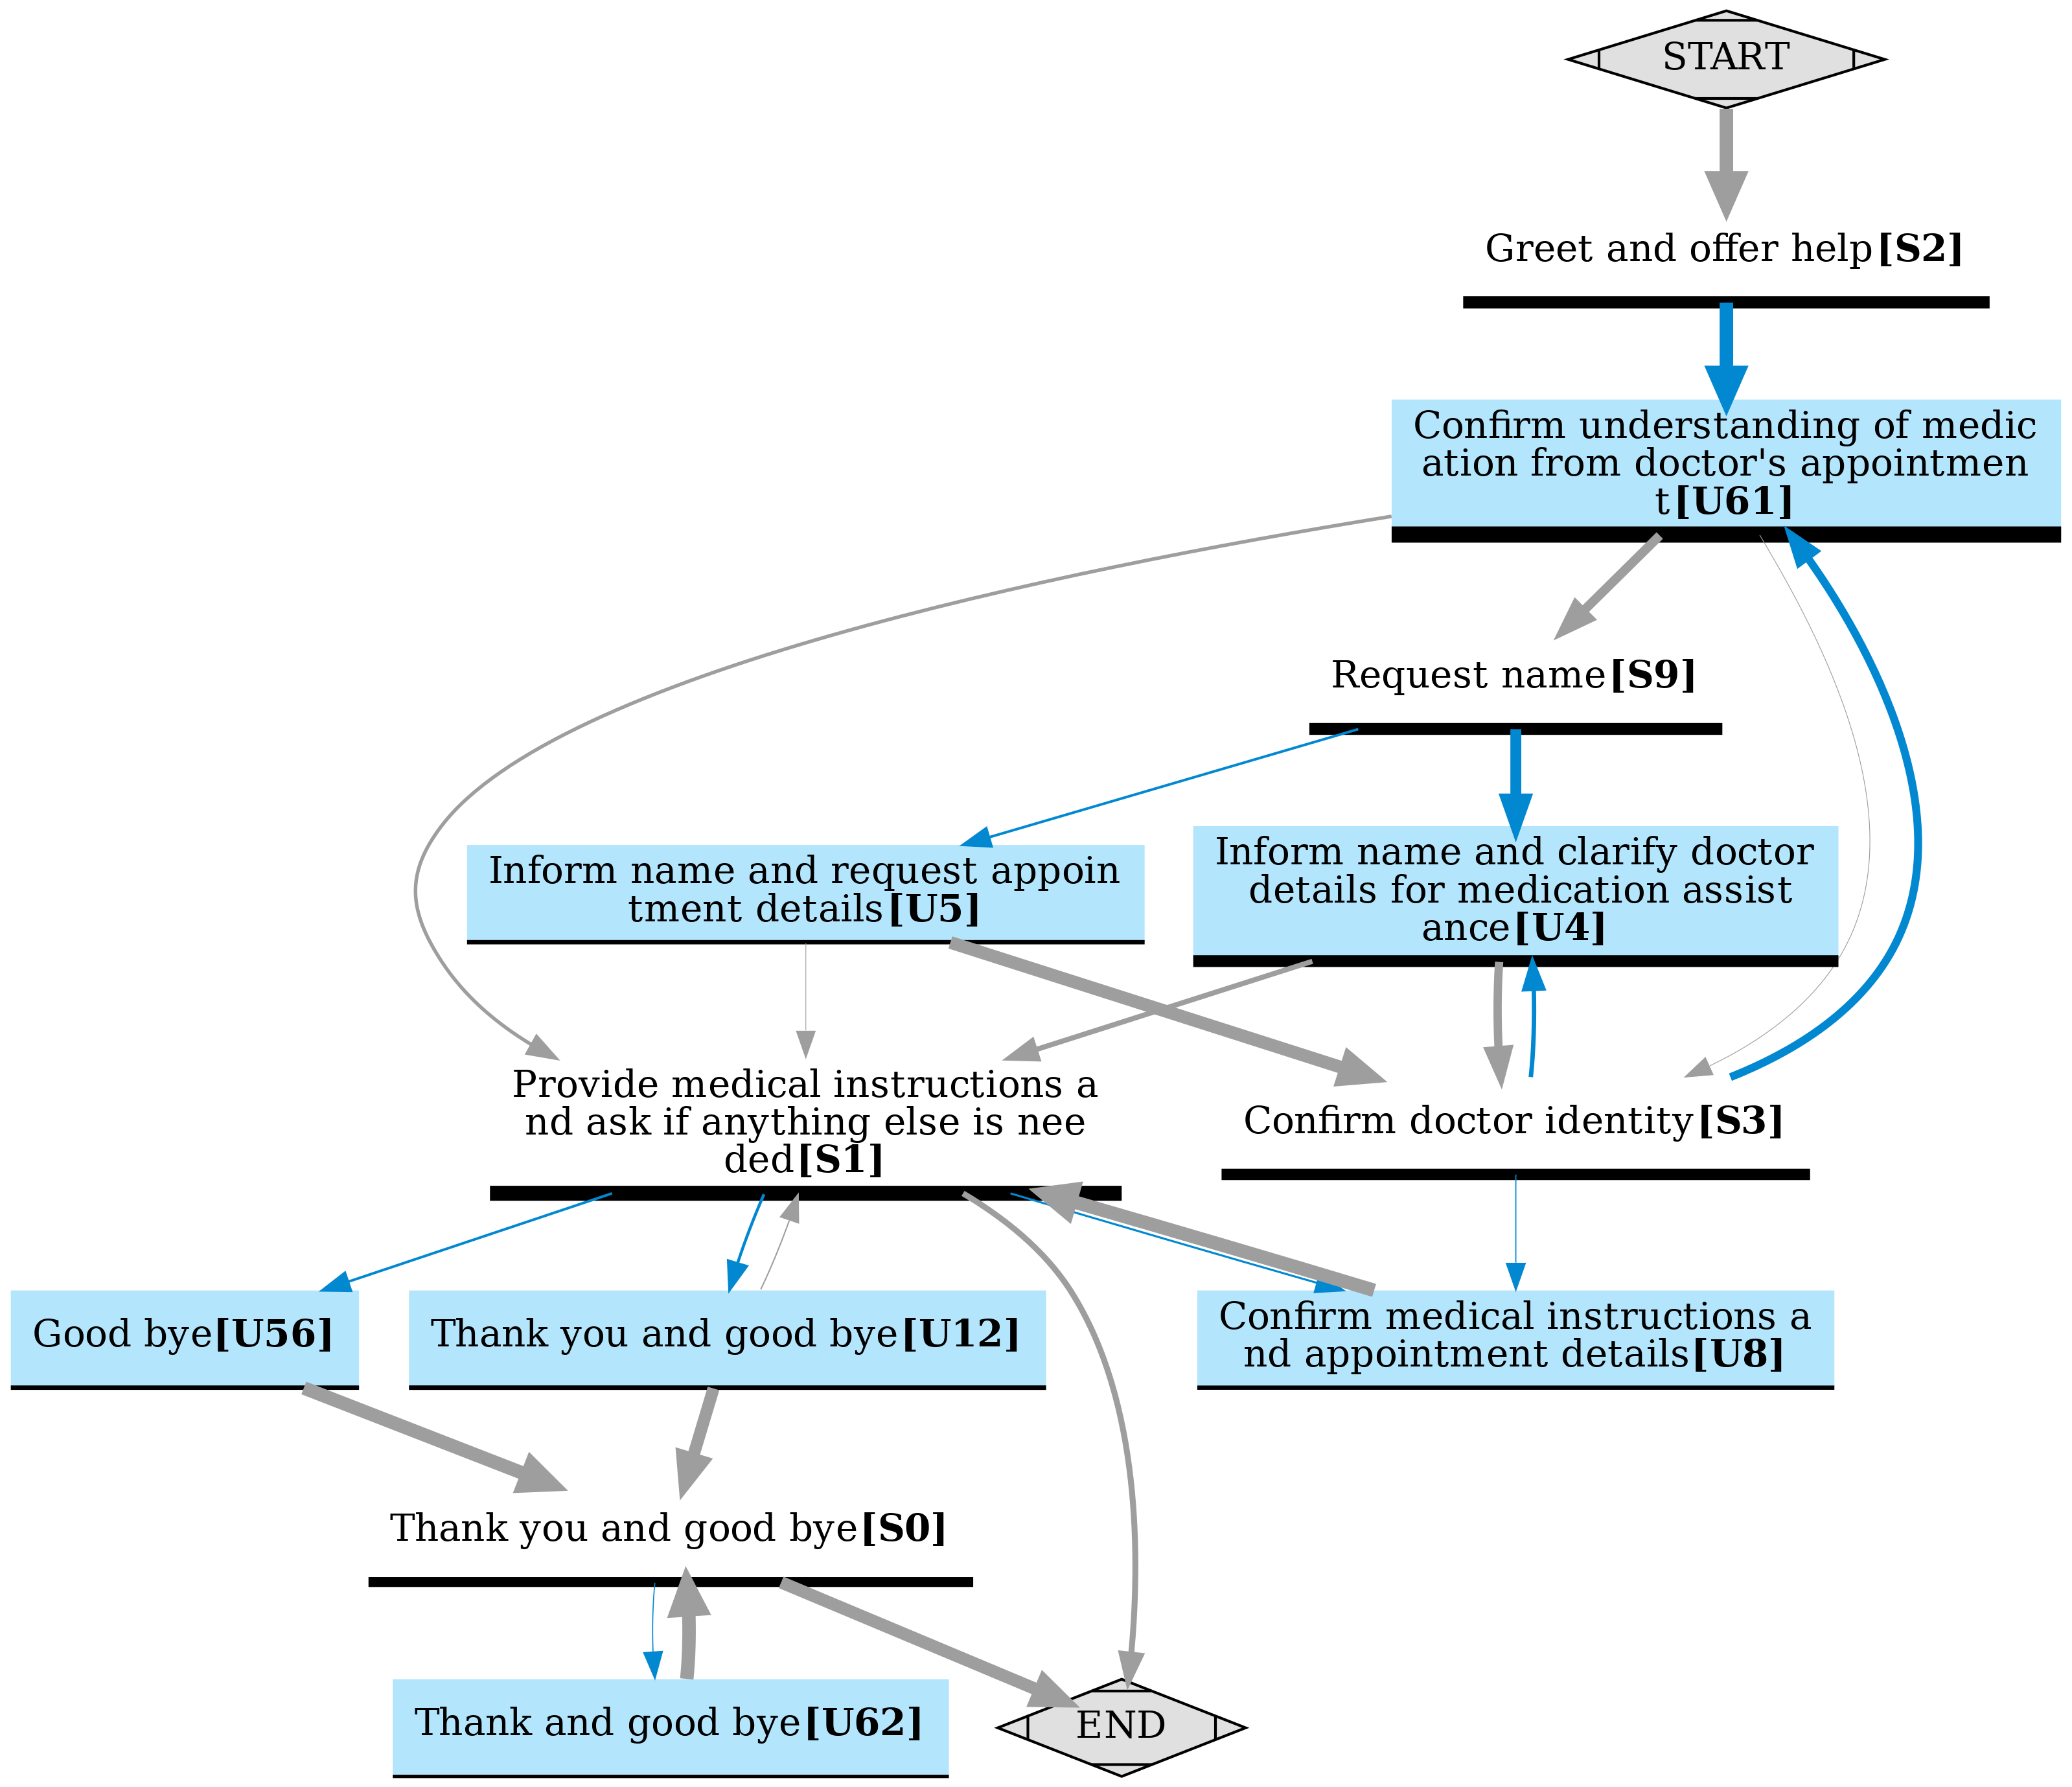

[2025-05-14 11:25:39,120.120]   Finished creating the graph.


In [51]:
_, _ = dialog2graph(PATH_ORCHESTRATION_DIALOGUES, node_thresholds=[10, 0.3])

# Can we quantify the difference?

> **TODO:** Add simple sentence transformer-cosine distance example which fails, so we leave this question open to be explored in the workshop